# 第10章: 10 Automated Hyperparameter Tuning

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] この章の内容を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Python基礎

⏱️ **推定学習時間**: 60-90分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 機械学習

---


## 💡 イントロダクション：なぜこれを学ぶのか？

### モチベーション

[この章の重要性を説明]

### 実世界での応用

[具体的な応用例]

---


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, loguniform, randint
from sklearn.datasets import make_classification
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    cross_val_score, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Part 1: Setup Dataset

In [2]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate classification data
X, y = make_classification(
    n_samples=1500,
    n_features=20,
    n_informative=12,
    n_redundant=4,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(np.unique(y))}")

Training samples: 1200
Test samples: 300
Features: 20
Classes: 3


## Part 2: GridSearchCV Deep Dive

In [3]:
# ============================================================
# [コードの説明]
# ============================================================

# Define parameter grid for MLP
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

# Calculate total combinations
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)

print(f"Total parameter combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} model fits")

Total parameter combinations: 48
With 5-fold CV: 240 model fits


In [4]:
# ============================================================
# [コードの説明]
# ============================================================

# Run GridSearchCV
mlp = MLPClassifier(
    solver='adam',
    max_iter=300,
    early_stopping=True,
    random_state=42
)

grid_search = GridSearchCV(
    mlp,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.score(X_test_scaled, y_test):.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best CV Score: 0.8567
Test Score: 0.8067


In [5]:
# ============================================================
# [コードの説明]
# ============================================================

# Analyze results
results_df = pd.DataFrame(grid_search.cv_results_)

# Top 10 combinations
top_results = results_df.nsmallest(10, 'rank_test_score')[[
    'params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score'
]]

print("Top 10 Parameter Combinations:")
for idx, row in top_results.iterrows():
    print(f"\nRank {row['rank_test_score']}:")
    print(f"  Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    for param, value in row['params'].items():
        print(f"  {param}: {value}")

Top 10 Parameter Combinations:

Rank 1:
  Score: 0.8567 (+/- 0.0363)
  activation: relu
  alpha: 0.01
  hidden_layer_sizes: (100, 50)
  learning_rate_init: 0.01

Rank 2:
  Score: 0.8550 (+/- 0.0304)
  activation: relu
  alpha: 0.001
  hidden_layer_sizes: (100, 50)
  learning_rate_init: 0.01

Rank 3:
  Score: 0.8533 (+/- 0.0286)
  activation: relu
  alpha: 0.0001
  hidden_layer_sizes: (100, 50)
  learning_rate_init: 0.01

Rank 4:
  Score: 0.8483 (+/- 0.0195)
  activation: relu
  alpha: 0.001
  hidden_layer_sizes: (50, 25)
  learning_rate_init: 0.01

Rank 5:
  Score: 0.8442 (+/- 0.0174)
  activation: relu
  alpha: 0.0001
  hidden_layer_sizes: (50, 25)
  learning_rate_init: 0.01

Rank 6:
  Score: 0.8425 (+/- 0.0148)
  activation: relu
  alpha: 0.01
  hidden_layer_sizes: (50, 25)
  learning_rate_init: 0.01

Rank 6:
  Score: 0.8425 (+/- 0.0300)
  activation: tanh
  alpha: 0.01
  hidden_layer_sizes: (100, 50)
  learning_rate_init: 0.01

Rank 8:
  Score: 0.8383 (+/- 0.0279)
  activation: tanh

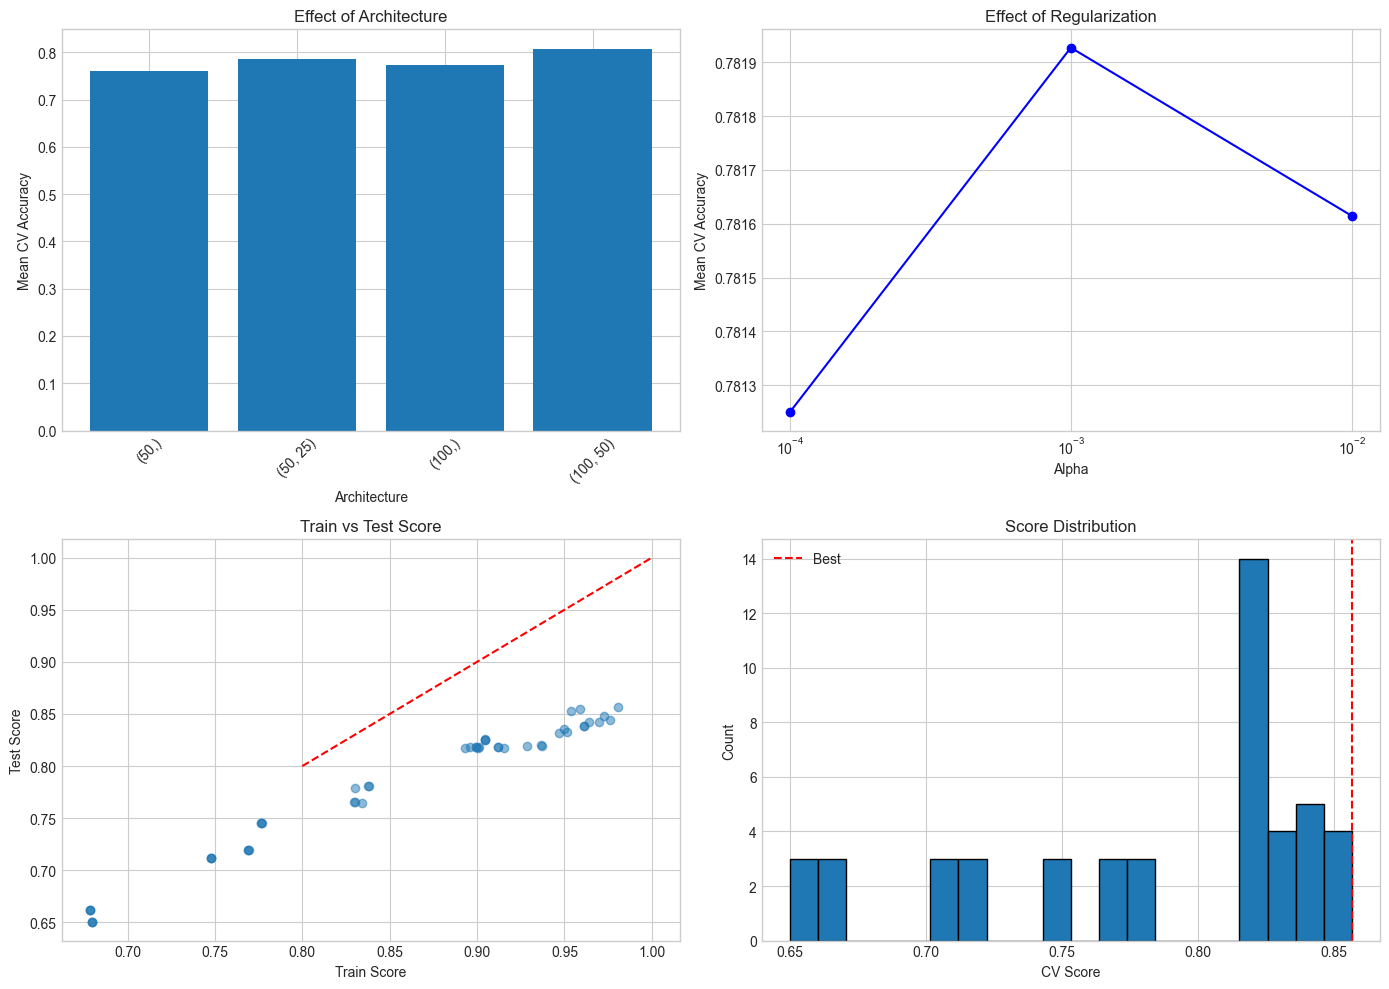

In [6]:
# Visualize grid search results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Architecture comparison
arch_scores = results_df.groupby('param_hidden_layer_sizes')['mean_test_score'].mean()
axes[0, 0].bar([str(a) for a in arch_scores.index], arch_scores.values)
axes[0, 0].set_xlabel('Architecture')
axes[0, 0].set_ylabel('Mean CV Accuracy')
axes[0, 0].set_title('Effect of Architecture')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Alpha comparison
alpha_scores = results_df.groupby('param_alpha')['mean_test_score'].mean()
axes[0, 1].plot(alpha_scores.index, alpha_scores.values, 'bo-')
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlabel('Alpha')
axes[0, 1].set_ylabel('Mean CV Accuracy')
axes[0, 1].set_title('Effect of Regularization')

# 3. Train vs Test scores
axes[1, 0].scatter(results_df['mean_train_score'], results_df['mean_test_score'], alpha=0.5)
axes[1, 0].plot([0.8, 1], [0.8, 1], 'r--')
axes[1, 0].set_xlabel('Train Score')
axes[1, 0].set_ylabel('Test Score')
axes[1, 0].set_title('Train vs Test Score')

# 4. Score distribution
axes[1, 1].hist(results_df['mean_test_score'], bins=20, edgecolor='black')
axes[1, 1].axvline(x=grid_search.best_score_, color='r', linestyle='--', label='Best')
axes[1, 1].set_xlabel('CV Score')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Score Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Part 3: RandomizedSearchCV for Large Spaces

In [7]:
# Define continuous distributions
param_distributions = {
    'hidden_layer_sizes': [
        (50,), (100,), (200,),
        (50, 25), (100, 50), (200, 100),
        (100, 50, 25), (200, 100, 50)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': loguniform(1e-5, 1e-1),  # Log-uniform distribution
    'learning_rate_init': loguniform(1e-4, 1e-1),
    'batch_size': [32, 64, 128, 256]
}

# RandomizedSearchCV
mlp = MLPClassifier(
    solver='adam',
    max_iter=300,
    early_stopping=True,
    random_state=42
)

random_search = RandomizedSearchCV(
    mlp,
    param_distributions,
    n_iter=50,  # Number of random samples
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

random_search.fit(X_train_scaled, y_train)

print(f"\nBest CV Score: {random_search.best_score_:.4f}")
print(f"Test Score: {random_search.score(X_test_scaled, y_test):.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CV Score: 0.8500
Test Score: 0.8033


In [8]:
# ============================================================
# [コードの説明]
# ============================================================

# Best parameters from random search
print("Best Parameters (RandomizedSearchCV):")
for param, value in random_search.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")

Best Parameters (RandomizedSearchCV):
  activation: tanh
  alpha: 0.000216
  batch_size: 256
  hidden_layer_sizes: (200, 100, 50)
  learning_rate_init: 0.008967


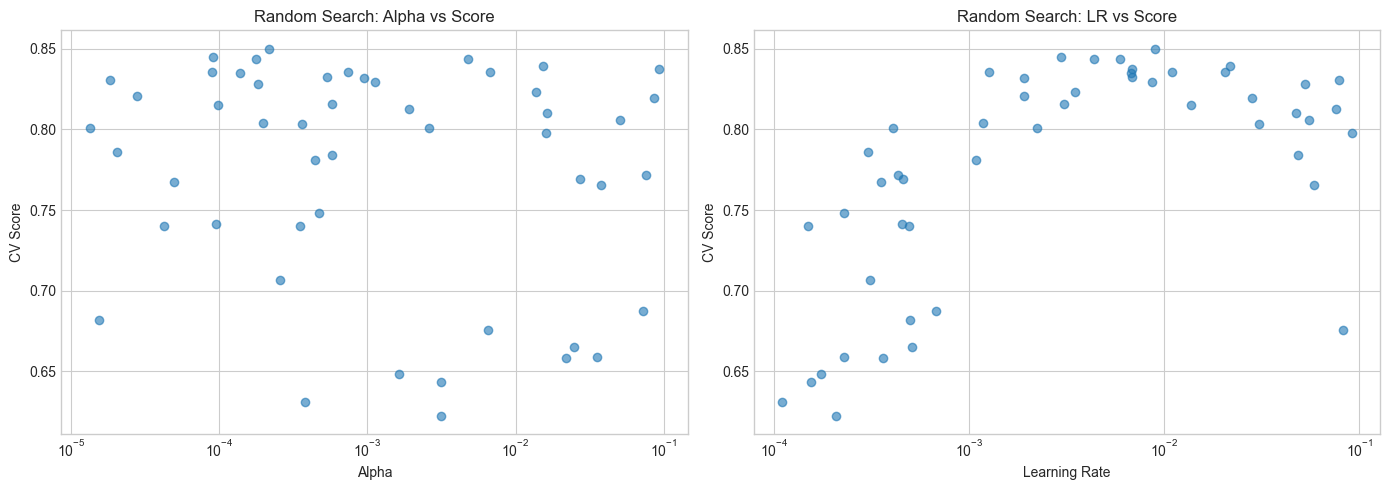

In [9]:
# Visualize random search exploration
random_results = pd.DataFrame(random_search.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Alpha vs Score
axes[0].scatter(random_results['param_alpha'], random_results['mean_test_score'], alpha=0.6)
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('CV Score')
axes[0].set_title('Random Search: Alpha vs Score')

# Learning rate vs Score
axes[1].scatter(random_results['param_learning_rate_init'], random_results['mean_test_score'], alpha=0.6)
axes[1].set_xscale('log')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('CV Score')
axes[1].set_title('Random Search: LR vs Score')

plt.tight_layout()
plt.show()

## Part 4: Multiple Scoring Metrics

In [10]:
# Search with multiple metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision': 'precision_macro',
    'recall': 'recall_macro'
}

param_grid_small = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'alpha': [0.001, 0.01]
}

mlp = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=300,
    early_stopping=True,
    random_state=42
)

multi_score_search = GridSearchCV(
    mlp,
    param_grid_small,
    cv=5,
    scoring=scoring,
    refit='accuracy',  # Use accuracy to select best model
    n_jobs=-1,
    return_train_score=True
)

multi_score_search.fit(X_train_scaled, y_train)

# Results for each metric
print("Multi-metric Search Results:")
print("="*60)

results = pd.DataFrame(multi_score_search.cv_results_)
for metric in scoring.keys():
    best_idx = results[f'mean_test_{metric}'].idxmax()
    best_score = results.loc[best_idx, f'mean_test_{metric}']
    best_params = results.loc[best_idx, 'params']
    print(f"\n{metric}:")
    print(f"  Best Score: {best_score:.4f}")
    print(f"  Parameters: {best_params}")

Multi-metric Search Results:

accuracy:
  Best Score: 0.7808
  Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}

f1_macro:
  Best Score: 0.7810
  Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}

precision:
  Best Score: 0.7833
  Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}

recall:
  Best Score: 0.7807
  Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}


## Part 5: Tuning Different Models

In [11]:
# ============================================================
# [コードの説明]
# ============================================================

# Tune Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_search.fit(X_train_scaled, y_train)

print("Random Forest Best Parameters:")
for param, value in rf_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"CV Score: {rf_search.best_score_:.4f}")
print(f"Test Score: {rf_search.score(X_test_scaled, y_test):.4f}")

Random Forest Best Parameters:
  max_depth: 20
  min_samples_split: 2
  n_estimators: 200
CV Score: 0.8175
Test Score: 0.8233


In [12]:
# ============================================================
# [コードの説明]
# ============================================================

# Tune SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

svm_search = GridSearchCV(
    SVC(random_state=42),
    svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

svm_search.fit(X_train_scaled, y_train)

print("\nSVM Best Parameters:")
for param, value in svm_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"CV Score: {svm_search.best_score_:.4f}")
print(f"Test Score: {svm_search.score(X_test_scaled, y_test):.4f}")


SVM Best Parameters:
  C: 1
  gamma: 0.1
  kernel: rbf
CV Score: 0.8483
Test Score: 0.8267


In [13]:
# ============================================================
# [コードの説明]
# ============================================================

# Compare best models
models = {
    'MLP': grid_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'SVM': svm_search.best_estimator_
}

print("\nModel Comparison (Best Tuned Models):")
print("="*50)

comparison_results = []
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    test_score = model.score(X_test_scaled, y_test)
    
    comparison_results.append({
        'Model': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Score': test_score
    })
    
print(pd.DataFrame(comparison_results).to_string(index=False))


Model Comparison (Best Tuned Models):
        Model  CV Mean   CV Std  Test Score
          MLP 0.856667 0.036286    0.806667
Random Forest 0.817500 0.016750    0.823333
          SVM 0.848333 0.022608    0.826667


## Part 6: Best Practices

In [14]:
# ============================================================
# [コードの説明]
# ============================================================

print("Hyperparameter Tuning Best Practices:")
print("="*60)
print()
print("1. START COARSE, THEN REFINE")
print("   • Begin with wide parameter ranges")
print("   • Narrow down based on initial results")
print("   • Example: alpha in [0.0001, 0.01, 1] → [0.001, 0.005, 0.01]")
print()
print("2. CHOOSE RIGHT SEARCH METHOD")
print("   • GridSearchCV: Small parameter spaces (<100 combinations)")
print("   • RandomizedSearchCV: Large spaces, continuous parameters")
print()
print("3. USE APPROPRIATE CV")
print("   • 5-fold is standard")
print("   • StratifiedKFold for imbalanced classes")
print("   • Increase folds for small datasets")
print()
print("4. WATCH FOR OVERFITTING")
print("   • Compare train vs test scores")
print("   • High variance across folds = unstable")
print()
print("5. CONSIDER COMPUTATIONAL COST")
print("   • Use n_jobs=-1 for parallelization")
print("   • Start with fewer iterations/estimators")
print("   • Subsample data for initial exploration")

Hyperparameter Tuning Best Practices:

1. START COARSE, THEN REFINE
   • Begin with wide parameter ranges
   • Narrow down based on initial results
   • Example: alpha in [0.0001, 0.01, 1] → [0.001, 0.005, 0.01]

2. CHOOSE RIGHT SEARCH METHOD
   • GridSearchCV: Small parameter spaces (<100 combinations)
   • RandomizedSearchCV: Large spaces, continuous parameters

3. USE APPROPRIATE CV
   • 5-fold is standard
   • StratifiedKFold for imbalanced classes
   • Increase folds for small datasets

4. WATCH FOR OVERFITTING
   • Compare train vs test scores
   • High variance across folds = unstable

5. CONSIDER COMPUTATIONAL COST
   • Use n_jobs=-1 for parallelization
   • Start with fewer iterations/estimators
   • Subsample data for initial exploration


## Summary

In this notebook, you learned:

### Search Methods
- **GridSearchCV**: Exhaustive search, good for small spaces
- **RandomizedSearchCV**: Samples from distributions, good for large spaces

### Key Techniques
- Using log-uniform distributions for learning rates/regularization
- Multiple scoring metrics
- Analyzing and visualizing search results

### Key Takeaways
- Always use cross-validation
- Visualize parameter effects
- Compare train vs test scores for overfitting
- Start coarse, refine based on results

### Next Steps
Continue to **Notebook 11** for model comparison and selection!

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

次のノートブックへ

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
